# Filtering

Function to develop/test the filtering based on a checkerboard of white and grey squares.

## Initialization and imports

Imports libraries and initializes the communication with Thymio through USB port.

### Look-up table for ports:
Replace `/dev/cu.usbmodem142101` (or current port value) below by the correct computer port:

Lucas: `\\.\COM3` for USB-cable and `\\.\COM4` for USB-dongle

Emma: ` `

Elise: ` `

Océane: ` `

In [2]:
import time
import os
import sys
import serial
from math import *
import numpy as np
from numpy import random as rand

# Variable to know if Thymio has already been connected before or not (== 1 if it is the case)
try:
    CONNECC
except NameError:
    CONNECC = 0
    print('Thymio will be connected.')
else:
    if CONNECC:
        print('Thymio has already been connected to the computer')

# Adding the src folder in the current directory as it contains the script
# with the Thymio class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio

# Print the path to Python3 executable
# print(sys.executable)

if CONNECC == 0:
    th = Thymio.serial(port="\\.\COM3", refreshing_rate=0.1)
    print('Pablo has been connected to the computer')
    CONNECC = 1
    time.sleep(1)

Thymio has already been connected to the computer


In [ ]:
# TEST

th.set_var("motor.left.target", 100)
th.set_var("motor.right.target", 100)
time.sleep(1)

a = time.time()
b = a
while b - a < 1:
    print(th["motor.left.speed"], th["motor.right.speed"])
    b = time.time()
    
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

In [ ]:
th.set_var("motor.left.target", 100)
th.set_var("motor.right.target", 100)
a = time.time()
b = a
while b-a < 1.5:
    print(th["prox.ground.delta"])
    b = time.time()
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

## (Odometry)

Important stuff are the coefficients for the odometry and the global structure of the code to make the Thymio moves towards the defined goal:

In [ ]:
counter = 0
VelLeft = 100
VelRight = -100
adjust = 1.9 #4.15
SpeedGain = adjust*0.0325 * 10**(-3)
timer = 1 * 10**(-3) # 1ms
b = 0.095 # distance between Thymio's wheels in m

X = 0
Y = 0
Theta = 0

t = 0

while counter < 1000:
    #a = time.time()
    counter += 1
    th.set_var("motor.right.target", VelRight)
    th.set_var("motor.left.target", VelLeft)

    DTheta = SpeedGain*(VelLeft - VelRight)/(2*b)
    DS = SpeedGain*(VelLeft + VelRight)/2
    
    Theta += DTheta
    X += DS*cos(radians(Theta))
    Y += DS*sin(radians(Theta))

    time.sleep(timer)
    #b = time.time()
    #t += b-a

#print(t)
th.set_var("motor.right.target", 0)
th.set_var("motor.left.target", 0)

print(X)
print(Y)
print(Theta)

## To do:

- Définir fonctions et classes utiles à l'ensemble du déplacement du Thymio
    - markers2reality traduit les coordonnées des cases du damier en cm DONE
    - Thymio contient la position du Thymio ainsi que permet de régler la vitesse des roues et récupérer les informations relatives aux différents capteurs DONE
    - Kalmanfilter est la classe qui contiendra les différentes matrices nécessaires au filtrage
        - Concernant le filtrage en lui-même: état X = (x, y, theta); A = matrice identité; B = odometry (change avec l'état du Thymio, car varie avec l'angle du Thymio, voir slides 19-20 cours sur la localisation) dont un exemple se trouve ci-dessus, les facteurs adjust et 0.0325 sont déduit par expériences, ils changeront probablement dû au chgt de la durée d'une boucle par rapport à l'exemple ci-dessus, il faudra donc préalablement dire que l'odométrie est parfaite, faire des tests pour voir si l'odométrie est satisfaisante ou non* (voir notes en bas); C = matrice identité si mesures == prédictions, sinon il faut changer les valeurs (c'est la dernière grande inconnue, je pense que ça se fait par intuitions premièrement, et ensuite à tâtons lors des tests, ne vous embêtez pas trop avec ça pour le moment, dîtes que c'est égal à 2 fois l'identité par exemple)
    - Si d'autres fonctions/classes vous semblent intéressantes à créer vous gêner pas évidemment
- Créer la boucle principale, celle-ci doit effectuer les tâches suivantes dans cet ordre:
    - Initialiser la classe Thymio avec la start position voulue
    - Déterminer la vitesse qu'il faut appliquer aux roues afin d'atteindre le prochain objectif (qu'il faut définir évidemment, ça peut simplement se faire par coordonnées des cases évidemment)
    - Bouger le thymio 
    - Appliquer le filtrage pour déterminer la nouvelle position du Thymio
    - Si le goal est considéré comme atteint (|X - goal| < epsilon, tel que epsilon << 1), alors définir goal suivant, sauf si c'était la fin, dans ce cas, Pablo commence à faire du break dance.
    
*NOTES*: lorsque vous aurez tout coder, il faudra tester le tout en disant que l'odométrie est parfaite, mais en faisant quand même tous les calculs de filtrage!!! Pour déterminer les coefficients d'ajustement de l'odométrie qui dépendent forcément de la durée d'une boucle complète!
Evidemment, ne suivez pas bêtement cette liste de choses à faire si vous pensez qu'il est possible de faire mieux, je ne suis pas Dieu, j'ai pratiquement rien foutu hier soir.
    

## Definitions

### Functions

#### markers2reality:

This function gives the position in real coordinates (cm) of the given markers coordinates (matrix coordinates). The checkerboard pattern has 6cm sided squares:

In [6]:
def markers2reality(mx, my):
    x = (2*mx + 1)*3
    y = (2*my + 1)*3
    return x,y

In [7]:
def convert_cm_to_grid(x,y):
    x_grid = floor(x/size_marker_cm)
    y_grid = floor(y/size_marker_cm)
    return [x_grid,y_grid]

#### ground_sensor_theoretical:

In [8]:
def gst(pos, occupancy_grid): #theta in degrees, x, y, in cm
    pos_grid = convert_cm_to_grid(pos[0],pos[1])
    alpha = 9
    dist_sensor_center = 7.9
    
    if (pos[0]<0) or (pos[1]<0) or (pos_grid[0]>max_val_x) or (pos_grid[1]>max_val_y):
        print('ERROR : Thymio out of the grid')
        return
    pos_sensor_left = [dist_sensor_center*sin((90 - pos[2] - alpha)*pi/180), 
                       dist_sensor_center*cos((90 - pos[2] - alpha)*pi/180)]
    pos_sensor_right = [dist_sensor_center*sin((90 - pos[2] + alpha)*pi/180),
                        dist_sensor_center*cos((90 - pos[2] + alpha)*pi/180)]
    
    pos_sensor_left_grid = convert_cm_to_grid(pos[0] + pos_sensor_left[0], pos[1] + pos_sensor_left[1])
    pos_sensor_right_grid = convert_cm_to_grid(pos[0] + pos_sensor_right[0], pos[1] + pos_sensor_right[1])
    #print("POS SENSOR GRID: ",pos_sensor_left_grid, pos_sensor_right_grid)
    
    left = occupancy_grid[int(pos_sensor_left_grid[0]), int(pos_sensor_left_grid[1])]
    right = occupancy_grid[int(pos_sensor_right_grid[0]), int(pos_sensor_right_grid[1])]
    return [left, right]

### Classes

#### Pablo

This class designates the robot, including its state (x, y and theta) and the different functions that control its displacement:

In [253]:
class robot:
    def __init__(self, x, y): # x and y are in cm, theta in degrees
        self.x = x
        self.y = y
        self.theta = 90
        self.ground = [0,0]
        self.front = [0,0,0,0,0]
    
    def set_pos(self, pos):
        self.x = pos[0]
        self.y = pos[1]
        self.theta = pos[2]
    
    def get_ground(self):
        delta_threshold = 750
        self.ground = th["prox.ground.delta"]
        if self.ground[0] > delta_threshold:
            self.ground[0] = 0
        else:
            self.ground[0] = 5
        if self.ground[1] > delta_threshold:
            self.ground[1] = 0
        else:
            self.ground[1] = 5
        return self.ground
        
    def get_front(self):
        self.front = th["prox.horizontal"][0:4]
        return self.front
    
    def speed(self):
        return th["motor.left.speed"], th["motor.right.speed"]
    
    def move(self, u): # soit simplement set la vitesse des roues, possible de faire l'odometry ici aussi je pense
        
        # Move thymio depending on the control inputs u
        if u[0] >= 0:
            th.set_var("motor.left.target", u[0])
        else:
            th.set_var("motor.left.target", 2**16 + u[0])
        if u[1] >= 0:
            th.set_var("motor.right.target", u[1])
        else:
            th.set_var("motor.right.target", 2**16 + u[1])
        
    def nopuedo(self): # je sais pas encore ce que c'est, mais ce sera quelque chose j'imagine, jpp, arg, prout, pouet
        pass
    
        
    def __repr__(self): # called when print(Thymio) is used
        return "(x, y, theta) = (%.2f, %.2f, %.1f)" %(self.x, self.y, self.theta)

#### Filter:

Gives the control input to the Thymio.

In [ ]:
class Filter:
    def __init__(self, next_goal):
        self.next_goal = next_goal
        self.mode = 'rotate'
    
    def define_mode(self, pos)
        
        
    def control_input(self,pos,occupancy_grid):
        condition_left = (self.next_goal[0] == ground_sensor_theoretical(pos,occupancy_grid)[0])
        condition_right = (self.next_goal[1] == ground_sensor_theoretical(pos,occupancy_grid)[1])
        if (condition_left and condition_right):
            u = [100, 100]
        elif (condition_left and (not condition_right)):
            u = [-50, 50]
        elif ((not condition_left) and condition_right):
            u = [50, -50]
        else
            u = [100, 100]
            
        

In [ ]:
def closest_possible_state(occupancy_grid, robot):
    found = 0
    pos = robot.pos()
    for distance in np.linspace(0.1,2,20):
        for angle in np.linpsace(0,15,16):
            if (gst(pos + [distance*cos(pos[2] + angle), distance*sin(pos[2] + angle), pos[2] + angle], occupancy_grid)
                == robot.get_ground()):
                y = pos + [distance*cos(pos[2] + angle), distance*sin(pos[2] + angle), angle]
                found = 1
            elif (gst(pos + [distance*cos(pos[2] - angle), distance*sin(pos[2] - angle), pos[2] - angle], occupancy_grid)
                == robot.get_ground()):
                y = pos + [distance*cos(pos[2] - angle), distance*sin(pos[2] - angle), -angle]
                found = 1
            if found == 1:
                break
        if found == 1:
            break
    return y
            
            

In [10]:
def convert_aseba_to_speed(u):
    b = 0.095
    adjust = 0.06 #* 10**(-3)
    odo_coeff = [adjust, adjust/3 * pi/180]
    
    dtheta = odo_coeff[1]*(u[1]-u[0])/(b)
    ds = odo_coeff[0]*(u[0] + u[1])/2
    return [ds, dtheta]

In [11]:
def elapsed_time(t):
    return time.time(), time.time() - t

In [67]:
print(convert_aseba_to_speed([100,-100]))

t1 = time.time()
t2 = time.time()
print(t2-t1)

[0.0, -0.7348754745239282]
0.0009970664978027344


In [65]:
u = [100, 100]
#th.set_var("motor.left.target", u[0])
#th.set_var("motor.right.target", 2**16 + u[1])
x = 0
theta = 0
time1 = time.time()
t = [time.time(),time.time(), time.time()]
while time.time() - t[2] < 1:
    x += convert_aseba_to_speed(u)[0]*(time.time() - t[1] + 2.5*10**(-7)) # 0.25 us d'éxécution de la ligne
    t[1] = time.time()
    theta += convert_aseba_to_speed(u)[1]*(time.time() - t[0] + 2.5*10**(-7))
    t[0] = time.time()

print(x, theta)    
u = [0,0]
#th.set_var("motor.left.target", u[0])
#th.set_var("motor.right.target", u[1])

6.0272896536217315 0.0


#### Kalmanfilter

Extended Kalman filter called at each iteration after Thymio's movement. See lecture on Uncertainties slides 33-end. Previous lecture on Localisation might be useful as well, odometry slides 19-20 and intro. to uncertainties slides 23-37.

In [291]:
class Kalmanfilter:
    def __init__(self, robot, t_init):
        self.A = np.array([[1,0,0,T,0,0][0,1,0,0,T,0],[0,0,1,0,0,T],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]) # jacobian, constant
        #self.B = 
        self.C = np.array([[[0,0,0,0,0,0][0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]],
                           [[1,0,0,0,0,0][0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]])
        self.R = np.array([[0.1,0,0,0,0,0][0,0.1,0,0,0,0],[0,0,0.1,0,0,0],[0,0,0,0.1,0,0],[0,0,0,0,0.1,0],[0,0,0,0,0,0.1]]) # displacement noise covariance matrix
        self.Q = np.array([[0.1,0,0,0,0,0][0,0.1,0,0,0,0],[0,0,0.1,0,0,0],[0,0,0,0.1,0,0],[0,0,0,0,0.1,0],[0,0,0,0,0,0.1]]) # measurement noise, constant
        self.mu = robot.pos # current mean, aka current state, MUST BE A VERTICAL VECTOR AS A NUMPY ARRAY 3x1
        self.Sigma = np.array([[0,0,0,0,0,0][0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]) # current covariance matrix
        self.b = 0.095 # distance between Thymio's wheels in m
        self.t = t_init
        # self.ground
        
    def predict(self, robot, occupancy_grid, u):
        # First step: preliminary prediction based only on odometry
        
        # Calculate B*u term by term because it is not linear, cosinus and sinus ma boi
        odo_coeff = 0.062 * 10**(-3) # random shit ma boi
        dtheta = odo_coeff*(u[0]-u[1])/(2*self.b)
        ds = odo_coeff*(u[0] + u[1])/2
        dx = ds*cos(radians(mu[2] + dtheta))
        dy = ds*sin(radians(mu[2] + dtheta))
        
        
        
        # Compute preliminary mû and Sigma
        self.mu = np.dot(self.A,self,mu) + np.array([[dx],[dy],[dtheta]])
        self.Sigma = np.dot(np.dot(self.A,self.Sigma),(self.A.T)) + self.R
        
        # Innovation step
        if gst(pos, occupancy_grid) != robot.get_ground(): # if expectation =/= reality, we take measure to correct
            y = closest_possible_state(occupancy_grid, robot)
            
            i = y - np.dot(C,self.mu)
            S = np.dot(C, np.dot(self.Sigma, C.T)) + self.Q
            K = np.dot(self.Sigma, np.dot(C.T, numpy.linalg.inv(S)))
            
            # Final step
            self.mu += np.dot(K, i)
            self.Sigma -= np.dot(K, np.dot(C, self.Sigma))
            
        return self.mu
    
    def innovation(self): # second step
        return 0
    
    def aposteriori(self): # final step
        return 0
    

In [212]:

class ParticlesF:
    def __init__(self, M, robot, t):
        self.M = M
        self.t = t
        for i in range(0,M):
            d = rand.rand()*3 # cm
            angle = rand.rand()*2*pi # angle to determine x and y with the distance d from the initial pos of Thymio
            x = d*cos(angle) + robot.x
            y = d*sin(angle) + robot.y
            theta = (rand.rand()-0.5)*pi/6 + robot.theta # orientation of the thymio believed between -15° and +15°
            
            if i == 0:
                self.particles = np.array([[x, y, theta]])
                self.w = np.array([1/self.M])
            else:
                self.particles = np.append(self.particles, [[x, y, theta]], axis = 0)
                self.w = np.append(self.w, [1/self.M], axis = 0)
            #print(self.particles[i])
    
    def estimation(self, u, pos):
        [ds, dtheta] = convert_aseba_to_speed(u)
        self.t, T = elapsed_time(self.t)
        esti = [0,0,0]
        esti[2] = pos[2] + dtheta*T
        esti[0] = pos[0] + ds*cos(radians(esti[2]))*T
        esti[1] = pos[1] + ds*sin(radians(esti[2]))*T
        # peut-être rajouter un peu d'aléatoire
        for i in range(0,self.M):
            self.particles[i,2] += dtheta*T
            self.particles[i,0] += ds*cos(self.particles[i,2])*T # peut-être appliquer cos(theta + dtheta/2) plutôt que cos(theta + dtheta)
            self.particles[i,1] += ds*sin(self.particles[i,2])*T
        
        return esti
    
    def believe(self, robot, u, occupancy_grid):
        # Prediction stepasse
        esti = ParticlesF.estimation(self, u, [robot.x, robot.y, robot.theta])
        gst_esti = gst(esti, occupancy_grid)
        weight_dic = {}
        for i in range(0,self.M):
            dist_to_esti = sqrt((esti[0] - self.particles[i,0])**2) + sqrt((esti[1] - self.particles[i,1])**2)
            #print(dist_to_esti)
            gst_part = gst(self.particles[i], occupancy_grid)
            if gst_part == gst_esti:
                gst_score = 2
            elif gst_part[0] != gst_esti[0] and gst_part[1] != gst_esti[1]:
                gst_score = 0
            else:
                gst_score = 1
            
            #print(gst_score)
            if dist_to_esti < 0.2:
                weight_dic[i] = 20 + 5*gst_score
                #print(self.w[i])
            else:
                weight_dic[i] = 20 + 5*gst_score
                #print(self.w[i])
        
        # Sort particles in the order of their weight
        weight_dic = sorted(weight_dic.items(), key=operator.itemgetter(1), reverse=True)
        selected = np.array([[0,0,0]])
        for i in range(0,self.M):
            if i == 0:
                selected[i] = self.particles[weight_dic[i][0]]
            else:
                selected = np.append(selected, [self.particles[weight_dic[i][0]]], axis = 0)
            self.w[i] = weight_dic[i][1]
        
        self.w = [i/sum(self.w) for i in self.w]
        self.particles = selected
        
        # Believasse stepasse
        for i in range(0,self.M):
            p = rand.rand()
            eliteSize = int(0.1*self.M)
            if (i > eliteSize and p > self.w[i]):
                d = rand.rand()*3 # cm
                angle = rand.rand()*2*pi # angle to determine x and y with the distance d from the initial pos of Thymio
                x = d*cos(angle) + esti[0]
                y = d*sin(angle) + esti[1]
                theta = (rand.rand()-0.5)*pi/6 + esti[2] # orientation of the thymio believed between -15° and +15°

                self.particles[i,:] = [x, y, theta]
                self.w[i] = 0.1/self.M
        self.w = self.w/sum(self.w) # peut-être ajouter mutation ?
        x = np.dot(self.particles[:,0], self.w.T)
        y = np.dot(self.particles[:,1], self.w.T)
        theta = np.dot(self.particles[:,2], self.w.T)
        return [x, y, theta]
        
                

In [ ]:
import numpy as np

In [13]:
def checkerboard(occupancy_grid):
    
    for x in range (0,max_val_x):
        for y in range (0,max_val_y):
            if not occupancy_grid[x,y]:
                if ((x + y)%2):
                    occupancy_grid[x,y] = marker_here
            
    return occupancy_grid

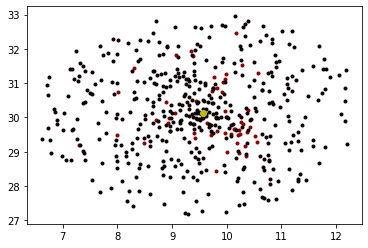

In [260]:
import numpy as np
from numpy import random as rand
from math import *
import time
import matplotlib.pyplot as plt
from matplotlib import colors
size_marker_cm = 6
max_val_x = 100
max_val_y = 100
marker_here = 5


occupancy = np.zeros((max_val_x, max_val_y))
occupancy = checkerboard(occupancy)
x, y = markers2reality(1,1)
Pablo = robot(x,y)
M = 500
particules = ParticlesF(M, Pablo, time.time())

u = [100,50]
t1 = time.time()
t2 = t1
while t2 - t1 < 5:
    Pablo.set_pos(particules.believe(Pablo, u, occupancy))
    t2 = time.time()
    

plt.figure()
for i in range(0,M):
    plt.plot(particules.particles[i,0], particules.particles[i,1], color=((M/10)*particules.w[i],0,0), marker='.')
plt.plot(Pablo.x, Pablo.y, 'yo')

In [56]:
import numpy as np

r = np.array([0])
for i in range(1,10):
    r = np.append(r, [i], axis=0)
print(r/sum(r))  

[0.         0.02222222 0.04444444 0.06666667 0.08888889 0.11111111
 0.13333333 0.15555556 0.17777778 0.2       ]


In [155]:
import operator

a = {}
b = [9,8,7,6,5,4,3,2,1,0]
for i in range(0,10):
    a[i] = rand.rand()
c = sorted(a.items(), key=operator.itemgetter(1), reverse=True)
print(c)
selected = []
for i in range(0,10):
    selected.append(b[c[i][0]])
print(selected)


[(7, 0.9152730994325984), (6, 0.7077528104310822), (2, 0.5896322579516724), (0, 0.46746230447980075), (3, 0.4421514269576329), (1, 0.3374943585647029), (5, 0.17510307774154388), (8, 0.16385165787725497), (4, 0.1617308292201356), (9, 0.03312388321608739)]
[2, 3, 7, 9, 6, 8, 4, 1, 5, 0]
